# 비확률 모델
---
- 비확률 모델은 2가지 종류가 있다. (1) SVM을 응용한 모델, (2) Decision Tree를 이용한 모델
---

# 서포트 벡터 머신
---

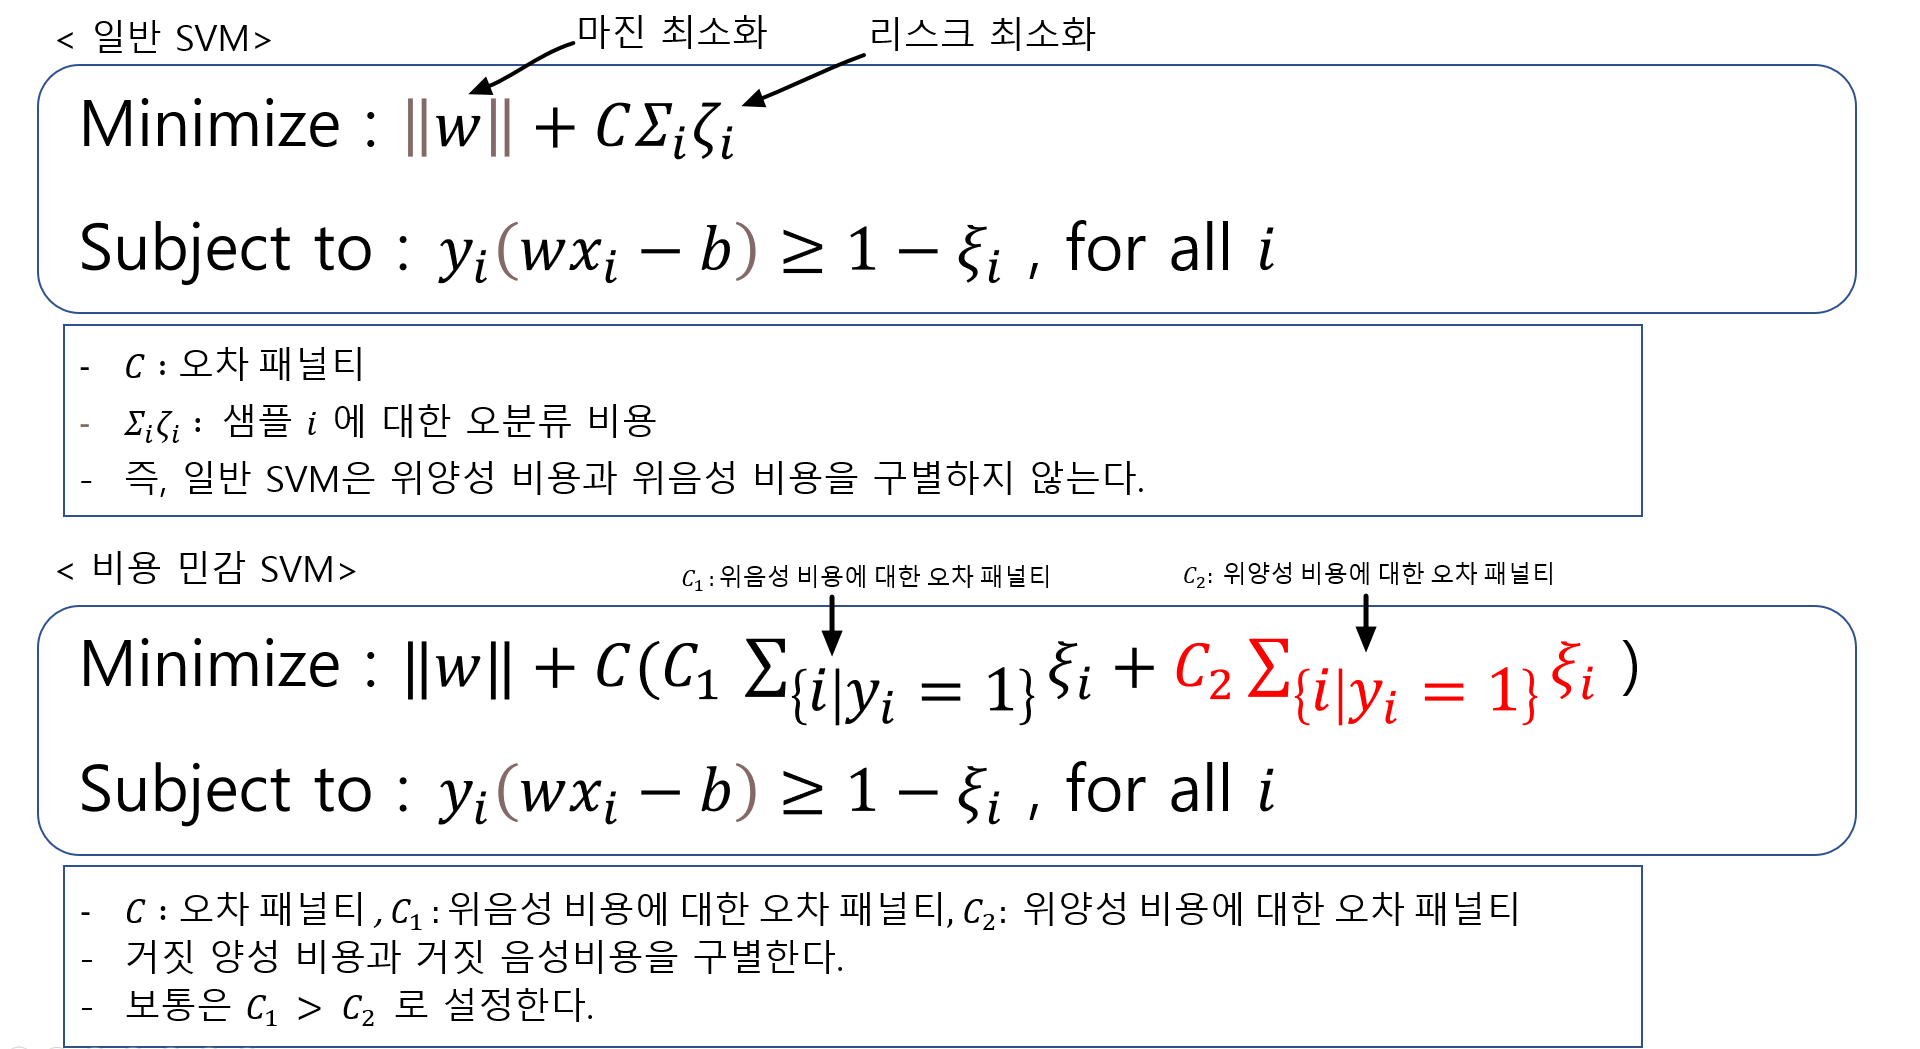

---

- 기본적인 SVM 모델은 샘플 i가 위음성비용인지, 위양성 비용인지 구분이 되어 있지 않다.
- 반대로 비용 민감 SVM은 위음성비용과 위양성 비용을 고려하고 있다.
- 위음성비용(긍정을 부정으로 오해한 비용)이 관심있는 분류값이므로 C1값을 더 크게 두는 것이다.

# Decision Tree 
---
- 일반적인 의사결정 나무 모델 뿐만이 아니라, Tree기반의 모델(KNN, RandomForest, XGBoost, LightGBM 등의 모델에도 적용가능한 이론)
- 소수 클래스에 대한 가중치를 부여해서 가급적이면 소수치로 분류되도록 조정하는 것이 핵심이다.
---

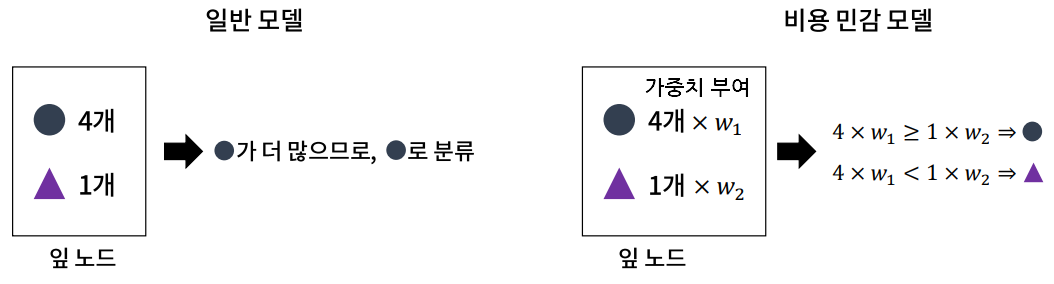

---
- 1) 위의 그림처럼 동그라미는 다수 클래스, 세모는 소수 클래스라 가정
- 2) [각 클래스별 샘플의 개수 x 가중치] 한 값을 비교해서 클래스를 판별한다.
- 2) w1을 1로두고 다수 클래스에 곱해주고, w2는 소수 클래스에 두고 `긍정이 부정보다 중요한 정도` 를 값으로 설정한다.
    - 일반적으로 w1을 1로 두고, w2를 클래스의 불균형 비율로 설정한다.

# 관련 문법 : class_weight
---

- DecisionTreeClassifier, SVC, RandomForestClassifier 등에있는 파라미터
- 사전 형태로 값을 입력한다.
    - key : class이름 (e.g : C1, C2)
    - value : class weight

- SVC로 예시를 든다면 아래와 같이 입력하게 된다.
```python
SVC(class_weight = {1:10, -1:1}) #클래스 1에 클래스-1의 10배만큼 가중치를 부여
```

In [1]:
import os
import pandas as pd

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

a=%pwd # 현재 경로 a에 할당
os.chdir(a) # 파일 로드 경로 설정

웹페이지의 특정 부분이 text인지 image인지를 정리한 언더샘플링 실습용 데이터

In [2]:
df = pd.read_csv("page-blocks0.csv")
df.head()

,Height,Lenght,Area,Eccen,P_black,P_and,Mean_tr,Blackpix,Blackand,Wb_trans,Class
0,5,7,35,1.400,0.400,0.657,2.33,14,23,6,negative
1,6,7,42,1.167,0.429,0.881,3.60,18,37,5,negative
2,6,18,108,3.000,0.287,0.741,4.43,31,80,7,negative
3,5,7,35,1.400,0.371,0.743,4.33,13,26,3,negative
4,6,3,18,500.000,0.500,0.944,2.25,9,17,4,negative


In [3]:
# 특징과 라벨 분리
X = df.drop('Class', axis = 1)
Y = df['Class']

In [4]:
# 학습 데이터와 평가 데이터 분할
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [5]:
# 클래스 불균형 확인 => 오버/언더샘플링을 적용하기에는 부적절 
Train_Y.value_counts()

negative    3684
positive     420
Name: Class, dtype: int64

클래스명을 1과 -1로 변경

In [6]:
Train_Y.replace({"negative":-1, "positive":1}, inplace = True)
Test_Y.replace({"negative":-1, "positive":1}, inplace = True)

In [7]:
# 클래스 불균형 비율 계산
Train_Y.value_counts().iloc[0] / Train_Y.value_counts().iloc[-1]

8.771428571428572

In [8]:
# kNN을 사용한 클래스 불균형 테스트
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *

# 모델 인스턴스 생성
kNN_model = KNN(n_neighbors = 11).fit(Train_X, Train_Y)

# 예측
pred_Y = kNN_model.predict(Test_X)

# 재현율 & 정확도
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

0.5755395683453237
0.9517543859649122


- 재현율이 66%로 불균형이 심각한 수준은 아닌 것으로 판단 된다.

# SVM을 통한 비용민감 모델 구현

In [9]:
from sklearn.svm import SVC

In [10]:
# 모델 인스턴스화 & fitting
model = SVC().fit(Train_X, Train_Y)

# 예측
pred_Y = model.predict(Test_X)

# 재현율 & 정확도 출력
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

0.17266187050359713
0.9137426900584795


- KNN과 비교했을때, 재현율이 급격하게 하락했다.(성능하락) 
- 이때문에 SVM이 클래스 분류에 있어 KNN보다 민감하다고 오해할 수 있다.
- 하지만 SVM 은 파라미터 수정을 전혀 하지 않은 것 (비용 민감 모델 실습위해 별도 지정하지 않음)
- 보편적으로 볼때는 되려 KNN보다 SVM이 클래스 분류 문제에 더 둔감하다(=강건하다)
    -FYI : `클래스 모델에 둔감하다/강건하다 (<-> 민감하다)` 라는 표현이 더 성능이 좋은 모델이다 라는 뜻

# SVM class_weight 조정

In [11]:
# 클래스 웨이트 조정
# 클래스 -1 대비 8배 큰 가중치를 클래스 1에 부여
model = SVC(class_weight = {1:8, -1:1}).fit(Train_X, Train_Y)
pred_Y = model.predict(Test_X)

# 재현율 & 정확도 출력
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

0.920863309352518
0.6747076023391813


- 재현율은 급격하게 상승했지만, 정확도가 60%대로 급격하게 하락했다.
- 여기서 부터는 분석가의 주관적 판단이 중요하다.
- 긍정클래스에 집중을 했기 때문에 위와 같은 가중치 조절이 이루어진 것이다.
- 하지만 부정 클래스에 대한 중요도를 좀더 고려(정확도 향상)을 원한다면 클래스 1에 대한 가중치 비율을 줄이는 식으로 조정이 가능할 것이다.